In [15]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import AdaBoostClassifier,AdaBoostRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import make_gaussian_quantiles
%matplotlib inline

In [14]:
# 生成2维正态分布，生成的数据按分位数分为两类，500个样本,2个样本特征，协方差系数为2
X1, y1 = make_gaussian_quantiles(cov=2.0,n_samples=500, n_features=2,n_classes=2, random_state=1)
# 生成2维正态分布，生成的数据按分位数分为两类，400个样本,2个样本特征均值都为3，协方差系数为2
X2, y2 = make_gaussian_quantiles(mean=(3, 3), cov=1.5,n_samples=400, n_features=2, n_classes=2, random_state=1)
# 将两组数据合成一组数据
X = np.concatenate((X1, X2))
y = np.concatenate((y1, - y2 + 1))

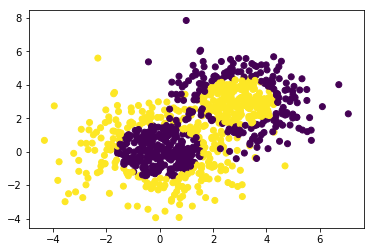

In [16]:
plt.scatter(X[:,0],X[:,1],marker='o',c=y)

可以看到数据有些混杂，我们现在用基于决策树的Adaboost来做分类拟合。

In [18]:
abc = AdaBoostClassifier(DecisionTreeClassifier(max_depth=2,min_samples_split=20,min_samples_leaf=5),
                         algorithm='SAMME',n_estimators=200,learning_rate=0.8)
abc.fit(X,y)

AdaBoostClassifier(algorithm='SAMME',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=20,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=0.8, n_estimators=200, random_state=None)

这里我们选择了SAMME算法，最多200个弱分类器，步长0.8，在实际运用中你可能需要通过交叉验证调参而选择最好的参数。拟合完了后，我们用网格图来看看它拟合的区域。

In [ ]:
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                     np.arange(y_min, y_max, 0.02))

Z = abc.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
cs = plt.contourf(xx, yy, Z, cmap=plt.cm.Paired)
plt.scatter(X[:, 0], X[:, 1], marker='o', c=y)

(690,)

In [23]:
print(abc.score(X,y))

0.9133333333333333


也就是说拟合训练集数据的分数还不错。当然分数高并不一定好，因为可能过拟合。

现在我们将最大弱分离器个数从200增加到300。再来看看拟合分数。

In [25]:
abc = AdaBoostClassifier(DecisionTreeClassifier(max_depth=2,min_samples_split=20,min_samples_leaf=5),
                         algorithm='SAMME',n_estimators=300,learning_rate=0.8)
abc.fit(X,y)
print(abc.score(X,y))

0.9622222222222222


这印证了我们前面讲的，弱分离器个数越多，则拟合程度越好，当然也越容易过拟合。

现在我们降低步长，将步长从上面的0.8减少到0.5，再来看看拟合分数。

In [28]:
abc = AdaBoostClassifier(DecisionTreeClassifier(max_depth=2,min_samples_split=20,min_samples_leaf=5),
                         algorithm='SAMME',n_estimators=300,learning_rate=0.5)
abc.fit(X,y)
print(abc.score(X,y))

0.8944444444444445


可见在同样的弱分类器的个数情况下，如果减少步长，拟合效果会下降。

最后我们看看当弱分类器个数为700，步长为0.7时候的情况：

In [29]:
abc = AdaBoostClassifier(DecisionTreeClassifier(max_depth=2,min_samples_split=20,min_samples_leaf=5),
                         algorithm='SAMME',n_estimators=700,learning_rate=0.7)
abc.fit(X,y)
print(abc.score(X,y))

0.9688888888888889


此时的拟合分数和我们最初的300弱分类器，0.8步长的拟合程度相当。也就是说，在我们这个例子中，如果步长从0.8降到0.7，则弱分类器个数要从300增加到700才能达到类似的拟合效果。

In [61]:
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split

In [63]:
# 加载糖尿病患者病人的数据集,并构造训练集和测试集
data = load_diabetes()
X_train,X_test,y_train,y_test = train_test_split(data.data,data.target,test_size=0.2,random_state=0)

In [100]:
abr = AdaBoostRegressor(learning_rate=0.8,n_estimators=300)
abr.fit(X_train,y_train)
print(abr.score(X_test,y_test))

0.27584439914307723


In [101]:
abr = AdaBoostRegressor(learning_rate=0.5,n_estimators=300)
abr.fit(X_train,y_train)
print(abr.score(X_test,y_test))

0.2729760665451638


In [96]:
abr = AdaBoostRegressor(learning_rate=0.5,n_estimators=100)
abr.fit(X_train,y_train)
print(abr.score(X_test,y_test))

0.28295469367814186


改变学习率和n_estimators都会较大影响到结果。而且我在实验时，发现这个集成学习的方法并不是很稳定,因为每次运行的结果都不太一样，但是结果的值差距不是很大在0.01级别。

In [77]:
from sklearn.svm import  LinearSVR
abr = AdaBoostRegressor(base_estimator=LinearSVR(epsilon=0.01,C=100),learning_rate=0.5,n_estimators=200)
abr.fit(X_train,y_train)
print(abr.score(X_test,y_test))

0.3566919604747466


In [79]:
abr = AdaBoostRegressor(base_estimator=LinearSVR(epsilon=0.01,C=100),learning_rate=0.5,n_estimators=200,loss='square')
abr.fit(X_train,y_train)
print(abr.score(X_test,y_test))

0.35547679677286576


In [80]:
abr = AdaBoostRegressor(base_estimator=LinearSVR(epsilon=0.01,C=100),learning_rate=0.5,n_estimators=200,loss='exponential')
abr.fit(X_train,y_train)
print(abr.score(X_test,y_test))

0.34622195210371604


可以看出改变loss对结果的改变并不明显，验证了我们在1中参数说明中所说的。

In [107]:
from sklearn.tree import  DecisionTreeRegressor
abr = AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=4,min_samples_split=20,min_samples_leaf=5),learning_rate=0.5,n_estimators=200)
abr.fit(X_train,y_train)
print(abr.score(X_test,y_test))

0.30689093849042304
